In [ ]:
!pip3 install gym
!pip3 install opencv-python
!pip3 install 'gym[atari]'
!pip3 install matplotlib

In [ ]:
# Factor A
# Risk/Reward --> Low High
# --------------> 0.5 2.0
# 
# 
# Factor B
# Sample Size/Buffer Size --> Low High
# --------------------------> 0.2 0.8
# 
# 
# Factor C
# Epsilon --> Low    High
# ----------> Linear Exponential

In [1]:
''' CHANGE ENVIRONMENT HERE'''
''' ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ '''
env_id = "PongNoFrameskip-v0"
''' ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ '''
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
from torch.autograd import Variable
import torch.nn.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

out_dir = 'outdir/'
out_dir_scoring = 'outdir_scoring_rewards/'

class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()

        self.input_shape = input_shape
        self.num_actions = num_actions

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

from wrappers import make_atari, wrap_deepmind, wrap_pytorch
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


    
def Training(risk="low",sample_ratio="low",epsilon_decay="low",buffer_size="low"):
    
    cur_ckpt_flnm = out_dir + 'outdir_{}_{}_{}_{}/current_{}_{}_{}_{}.ckpt'.format(risk,sample_ratio,epsilon_decay,buffer_size,risk,sample_ratio,epsilon_decay,buffer_size)
    cur_model_flnm = out_dir + 'outdir_{}_{}_{}_{}/current_{}_{}_{}_{}.model'.format(risk,sample_ratio,epsilon_decay,buffer_size,risk,sample_ratio,epsilon_decay,buffer_size)

    def plot(frame_idx, rewards, losses):
        clear_output(True)
        plt.figure(figsize=(20,5))
#         plt.subplot(131)
        plt.title('Reward Over %s Episodes, Average Reward: %.2f' % (frame_idx, np.mean(rewards)))
        plt.plot(rewards)
        plt.savefig(out_dir_scoring + 'scoring_rewards_{}_{}_{}_{}.png'.format(risk,sample_ratio,epsilon_decay,buffer_size))

#         plt.subplot(132)
#         plt.title('loss')
#         plt.plot(losses)
#         plt.savefig(out_dir + 'losses_{}_{}_{}_{}.png'.format(risk,sample_ratio,epsilon_decay,buffer_size))
        plt.show()


    from collections import deque

    class ReplayBuffer(object):
        def __init__(self, capacity):
            self.buffer = deque(maxlen=capacity)

        def push(self, state, action, reward, next_state, done):
            state      = np.expand_dims(state, 0)
            next_state = np.expand_dims(next_state, 0)

            self.buffer.append((state, action, reward, next_state, done))

        def sample(self, batch_size):
            state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
            return np.concatenate(state), action, reward, np.concatenate(next_state), done

        def __len__(self):
            return len(self.buffer)
    
    current_model = torch.load(cur_model_flnm)
    current_model.load_state_dict(torch.load(cur_ckpt_flnm))

    if USE_CUDA:
        current_model = current_model.cuda()

    optimizer = optim.Adam(current_model.parameters(), lr=0.00001)

    replay_initial = 10000
    replay_buffer = ReplayBuffer(10000)

    def get_epsilon_by_frame():
        epsilon_start = 1.0
        epsilon_final = 0.000000001

        epsilon_decay_steps = 1000000
            
        epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay_steps)
        plt.plot([epsilon_by_frame(i) for i in range(epsilon_decay_steps)])

        return epsilon_by_frame


    num_episodes = 100
    batch_size = 32
    gamma      = 0.99

    epsilon_by_frame = get_epsilon_by_frame()

    losses = []
    all_rewards = []
    episode_reward = 0
    episode=0

    state = env.reset()
#     env.render()
    while episode<num_episodes:
        epsilon = epsilon_by_frame(10000000)
        action = current_model.act(state, epsilon)

        next_state, reward, done, _ = env.step(action)

        state = next_state
        episode_reward += reward

        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0
            episode+=1
            plot(len(all_rewards), all_rewards, losses)
            

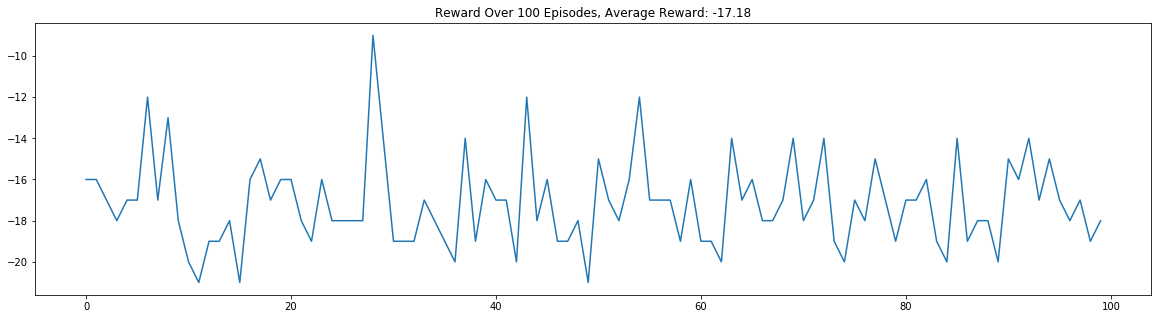

In [2]:
Training(risk="high",sample_ratio="high",epsilon_decay="high",buffer_size="high")